<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/aml_2324_w5_clf_ensembling_voter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Voter Ensemble (For Classification)

* 6G7V0017 Advanced Machine Learning, S2 W5
* Luciano Gerber

## Import Packages and Set Up Environment

In [ ]:
# latest version of scikit-learn: might need a kernel resta§rt
!pip install --upgrade scikit-learn==1.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 14.5 MB/s eta 0:00:00


In [ ]:
import sklearn
# this makes is easier for getting dataframes by default as input/output of
# sklearn pipelines
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

In [ ]:
# We will try different implementations of tree ensembles
# We are familiar with Random Forests; today, we'll use Boosted Trees as
# black boxes, but will revisit the intution behind them later in the unit

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# SHAP is not normally part of a standard Python distribution
# I am installing it here by asking the underlying operating system to
# `pip install` the package (`-q` for a quiet output)
!pip install -q shap
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.2 MB/s eta 0:00:00


## Dataset

In [ ]:
penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [ ]:
y = penguins['species']
X = penguins.drop(['species', 'island'], axis=1)
# are there any features that we shouldn't be using?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=0
)

## Reusable Pre-Processing and Model Fitting Pipelines

In [ ]:
def create_pp_ppln(X, scaling=False, poly=False):
    """creates a default preprocessing pipeline for numeric and categorical data
    using simple imputers, scalers, and encoders. It relies on latest versions
    of sklearn so as to produce pandas outputs.

    X: the dataset with the features (needed for feature names)

    returns the Pipeline object
    """

    numeric_features = X.select_dtypes(exclude='object').columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean"))
        ]
    )

    if scaling:
        numeric_transformer.steps.extend([
            ("scaler", StandardScaler())
        ])
    if poly:
        numeric_transformer.steps.extend([
            ('poly', PolynomialFeatures(include_bias=False))
        ])


    categorical_features = X.select_dtypes(include='object').columns.tolist()
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    return preprocessor

In [ ]:
def create_clf_ppln(est, X, scaling=False, poly=False):
    """ """
    clf_pipe = Pipeline(
        steps=[
            ("pp", create_pp_ppln(X, scaling, poly)),
            ("clf", est)
        ]
    )

    return clf_pipe

## Model Fitting

In [ ]:
gbc  = create_clf_ppln(GradientBoostingClassifier(max_depth=3), X_train)
rfc  = create_clf_ppln(RandomForestClassifier(max_depth=8), X_train)
knnc = create_clf_ppln(KNeighborsClassifier(5), X_train, scaling=True)
my_models = [ gbc, rfc, knnc ]

In [ ]:
model_results_list = []
for my_model in my_models:
    eval_results = cross_validate(
        my_model, X, y, cv=5,
        scoring='accuracy',
        return_train_score=True
    )
    model_results_list.append(
        (eval_results['test_score'].mean(), eval_results['test_score'].std(),
         eval_results['train_score'].mean(), eval_results['train_score'].std())
    )

In [ ]:
model_results = pd.DataFrame(
    model_results_list,
    columns=['test_mae_mean', 'test_mae_std', 'train_mae_mean', 'train_mae_std'],
    index=['gbc', 'rfc', 'knnc']
)

In [ ]:
model_results

,test_mae_mean,test_mae_std,train_mae_mean,train_mae_std
gbc,0.973828,0.016917,0.997818,0.001781
rfc,0.979582,0.014981,0.997818,0.001781
knnc,0.991262,0.007135,0.993457,0.002724


In [ ]:
for est in my_models:
    est.fit(X_train, y_train)

In [ ]:
ensemble = VotingClassifier(
    [
        ("gb", gbc),
        ("rf", rfc),
        ('knn', knnc)
    ],
    voting="soft"
)
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('gb',
                              Pipeline(steps=[('pp',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer())]),
                                                                                ['bill_length_mm',
                                                                                 'bill_depth_mm',
                                                                                 'flipper_length_mm',
                                                                                 'body_mass_g']),
                                                                               ('cat',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('ohe',
                                                                                                 OneHotEncoder(drop='if_binary',
                                                                                                               h...
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['bill_length_mm',
                                                                                 'bill_depth_mm',
                                                                                 'flipper_length_mm',
                                                                                 'body_mass_g']),
                                                                               ('cat',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('ohe',
                                                                                                 OneHotEncoder(drop='if_binary',
                                                                                                               handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                ['sex'])],
                                                                 verbose_feature_names_out=False)),
                                              ('clf',
                                               KNeighborsClassifier())]))],
                 voting='soft')

In [ ]:
eval_results = cross_validate(
    ensemble, X, y, cv=5,
    scoring='accuracy',
    return_train_score=True
)
ensemble_result = (
    eval_results['test_score'].mean(), eval_results['test_score'].std(),
    eval_results['train_score'].mean(), eval_results['train_score'].std()
)

In [ ]:
model_results.loc['ensemble'] = ensemble_result

In [ ]:
model_results

,test_mae_mean,test_mae_std,train_mae_mean,train_mae_std
gbc,0.973828,0.016917,0.997818,0.001781
rfc,0.979582,0.014981,0.997818,0.001781
knnc,0.991262,0.007135,0.993457,0.002724
ensemble,0.988363,0.010857,0.997818,0.001781


## Inspection of Ensemble Output

In [ ]:
y.unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [ ]:
gbc.predict_proba(X_test.iloc[[0]])

array([[9.99968019e-01, 2.08035230e-05, 1.11770545e-05]])

In [ ]:
# quickly adapted from the sklearn documentation
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html
xt = X.head(20)
yt = y.head(20)
pred1 = gbc.predict_proba(xt)[:, 0]
pred2 = rfc.predict_proba(xt)[:, 0]
pred3 = knnc.predict_proba(xt)[:, 0]
pred4 = ensemble.predict_proba(xt)[:, 0]

In [ ]:
pred1

array([0.9999966 , 0.99999173, 0.99999224, 0.49976542, 0.99999224,
       0.99999567, 0.99999404, 0.99999676, 0.99999567, 0.99999209,
       0.99996802, 0.999978  , 0.99883715, 0.99999563, 0.99999688,
       0.9999933 , 0.99999224, 0.99999292, 0.99999338, 0.99977118])

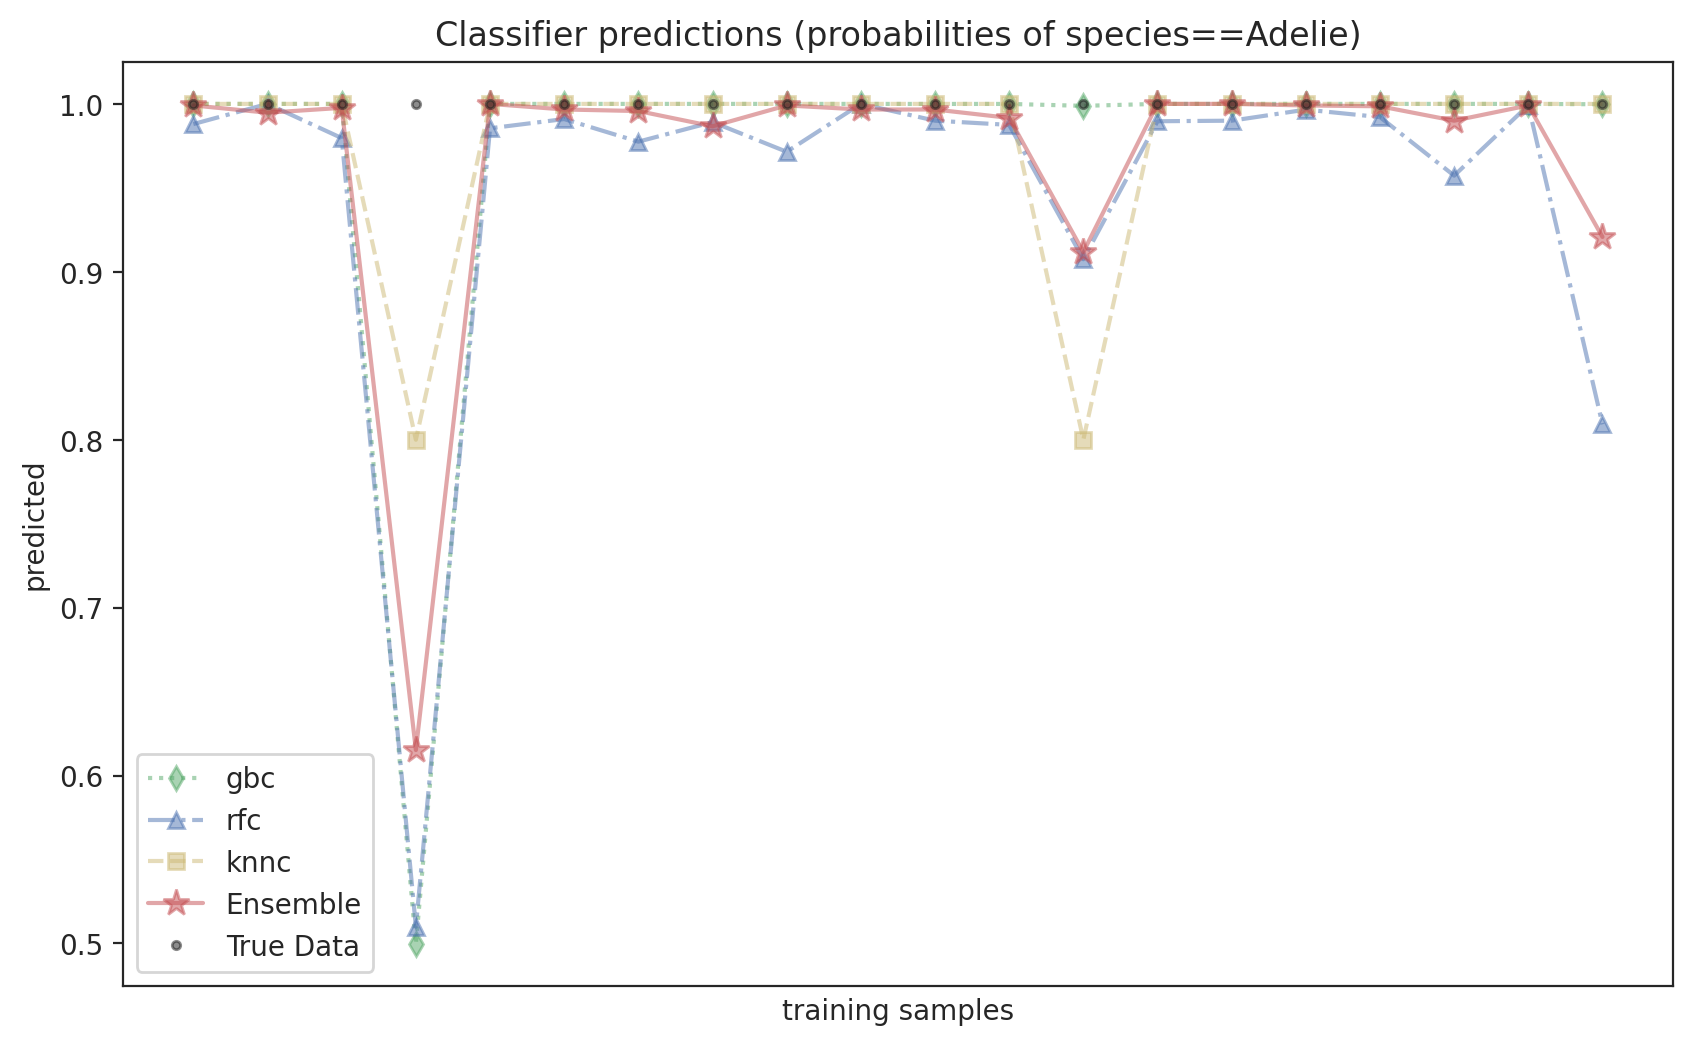

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
# plt.figure(figsize=(10,6))
ax.plot(pred1, "gd:", alpha=0.5, label="gbc")
ax.plot(pred2, "b^-.", alpha=0.5, label="rfc")
ax.plot(pred3, "ys--", alpha=0.5, label="knnc")
ax.plot(pred4, "r*-", alpha=0.5, ms=10, label="Ensemble")
ax.plot(yt=='Adelie', "ko", alpha=0.5, ms=3, label="True Data")
ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax.set_ylabel("predicted")
ax.set_xlabel("training samples")
ax.legend(loc="best")
ax.set_title("Classifier predictions (probabilities of species==Adelie)");

Also, we could simply have a hard voting ensembler and map the predictions of individual models and ensemble into a table.

In [ ]:
hardvoter = VotingClassifier(
    [
        ("gb", gbc),
        ("rf", rfc),
        ('knn', knnc)
    ],
    voting="hard"
)
hardvoter.fit(X_train, y_train)

VotingClassifier(estimators=[('gb',
                              Pipeline(steps=[('pp',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer())]),
                                                                                ['bill_length_mm',
                                                                                 'bill_depth_mm',
                                                                                 'flipper_length_mm',
                                                                                 'body_mass_g']),
                                                                               ('cat',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('ohe',
                                                                                                 OneHotEncoder(drop='if_binary',
                                                                                                               h...
                                                                                                 SimpleImputer()),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['bill_length_mm',
                                                                                 'bill_depth_mm',
                                                                                 'flipper_length_mm',
                                                                                 'body_mass_g']),
                                                                               ('cat',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('ohe',
                                                                                                 OneHotEncoder(drop='if_binary',
                                                                                                               handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                ['sex'])],
                                                                 verbose_feature_names_out=False)),
                                              ('clf',
                                               KNeighborsClassifier())]))])

In [ ]:
a_random_sample = X_test.sample(50, random_state=0)
# a_random_sample = X_test.head(20)
some_predictions = pd.DataFrame(
    dict(
        truth=y_test.loc[ a_random_sample.index ].values,
        gbc=gbc.predict(a_random_sample),
        rfc=rfc.predict(a_random_sample),
        knnc=knnc.predict(a_random_sample),
        ens=hardvoter.predict(a_random_sample)
    )
)

In [ ]:
some_predictions

,truth,gbc,rfc,knnc,ens
0,Gentoo,Gentoo,Gentoo,Gentoo,Gentoo
1,Adelie,Adelie,Adelie,Adelie,Adelie
2,Gentoo,Gentoo,Gentoo,Gentoo,Gentoo
3,Adelie,Adelie,Adelie,Adelie,Adelie
4,Gentoo,Gentoo,Gentoo,Gentoo,Gentoo
5,Gentoo,Gentoo,Gentoo,Gentoo,Gentoo
6,Chinstrap,Chinstrap,Chinstrap,Chinstrap,Chinstrap
7,Adelie,Adelie,Adelie,Adelie,Adelie
8,Gentoo,Gentoo,Gentoo,Gentoo,Gentoo
9,Adelie,Adelie,Adelie,Adelie,Adelie
